In [97]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import skimage
from skimage.transform import resize
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn import metrics
from keras.models import model_from_json

In [166]:
train_folder = './Indian Sign Language'
all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,1,./Indian Sign Language\1\0.png
1,1,./Indian Sign Language\1\1.png
2,1,./Indian Sign Language\1\10.png
3,1,./Indian Sign Language\1\100.png
4,1,./Indian Sign Language\1\1000.png
...,...,...
41934,Z,./Indian Sign Language\Z\995.png
41935,Z,./Indian Sign Language\Z\996.png
41936,Z,./Indian Sign Language\Z\997.png
41937,Z,./Indian Sign Language\Z\998.png


In [167]:
x_train,x_test = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_val = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [168]:
x_test

,label,path
9038,8,./Indian Sign Language\8\493.png
7430,7,./Indian Sign Language\7\125.png
3175,3,./Indian Sign Language\3\616.png
21693,I,./Indian Sign Language\I\882.png
21626,I,./Indian Sign Language\I\821.png
...,...,...
40792,Z,./Indian Sign Language\Z\1045.png
27217,N,./Indian Sign Language\N\453.png
22218,J,./Indian Sign Language\J\274.png
5035,5,./Indian Sign Language\5\13.png


In [169]:
print (f'Train data shape : {x_train.shape} \nTest data shape : {x_test.shape} \nValidate data shape : {x_val.shape}')

Train data shape : (30196, 2) 
Test data shape : (4194, 2) 
Validate data shape : (7549, 2)


In [170]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())

print (f'Number of classes : {no_of_classes}')

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

validation_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_val, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Number of classes : 35
Found 30196 validated image filenames belonging to 35 classes.
Found 7549 validated image filenames belonging to 35 classes.
Found 4194 validated image filenames belonging to 35 classes.


In [171]:
# base_model = VGG16(input_shape=(64,64,3), weights='imagenet', include_top=False)
# base_model = ResNet50(input_shape=(64,64,3), weights='imagenet', include_top=False)
# base_model = InceptionV3(input_shape=(64,64,3), weights='imagenet', include_top=False)
base_model = ResNet50V2(input_shape=(64,64,3), weights='imagenet', include_top=False)

In [172]:
base_model.trainable = False

In [173]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [174]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
# dense_layer_2 = layers.Dense(512, activation='relu')
# dropout_layer_2 = layers.Dropout(0.5)
prediction_layer = layers.Dense(no_of_classes, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    # dense_layer_2,
    # dropout_layer_2,
    prediction_layer
])

In [175]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2, 2, 2048)        23564800  
_________________________________________________________________
flatten_16 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               4194816   
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 35)                17955     
Total params: 27,777,571
Trainable params: 4,212,771
Non-trainable params: 23,564,800
_________________________________________________________________


In [176]:
epochs = 10
learning_rate = 0.0001

adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, 
                    shuffle=True)

c:\Users\chand\.conda\envs\gpu_env\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
236/236 [==============================] - 80s 325ms/step - loss: 0.9939 - accuracy: 0.7511 - val_loss: 0.1363 - val_accuracy: 0.9751
Epoch 2/10
236/236 [==============================] - 52s 221ms/step - loss: 0.1793 - accuracy: 0.9557 - val_loss: 0.0619 - val_accuracy: 0.9878
Epoch 3/10
236/236 [==============================] - 47s 200ms/step - loss: 0.0988 - accuracy: 0.9757 - val_loss: 0.0422 - val_accuracy: 0.9901
Epoch 4/10
236/236 [==============================] - 50s 213ms/step - loss: 0.0688 - accuracy: 0.9840 - val_loss: 0.0292 - val_accuracy: 0.9934
Epoch 5/10
236/236 [==============================] - 49s 207ms/step - loss: 0.0528 - accuracy: 0.9865 - val_loss: 0.0228 - val_accuracy: 0.9946
Epoch 6/10
236/236 [==============================] - 46s 193ms/step - loss: 0.0403 - accuracy: 0.9904 - val_loss: 0.0198 - val_accuracy: 0.9954
Epoch 7/10
236/236 [==============================] - 49s 206ms/step - loss: 0.0347 - accuracy: 0.9924 - val_loss: 0.0176 - val_ac

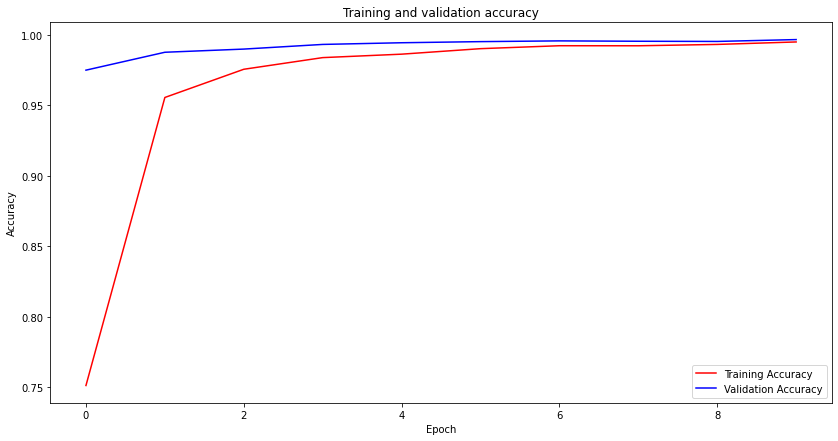

In [177]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

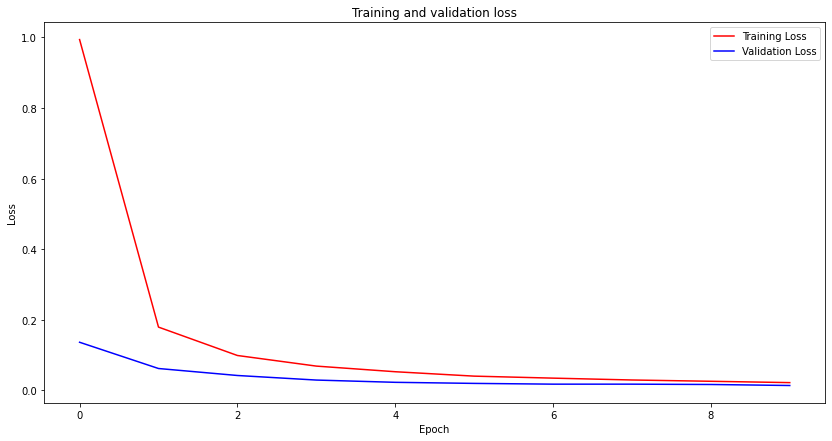

In [178]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

Inference result

In [179]:
print(list(test_generator.class_indices.keys()))

['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [180]:
predictions = model.predict(test_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

33/33 [==============================] - 8s 221ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       1.00      0.99      1.00       120
           5       0.99      1.00      1.00       120
           6       1.00      1.00      1.00       120
           7       1.00      1.00      1.00       120
           8       1.00      1.00      1.00       120
           9       1.00      1.00      1.00       120
           A       1.00      1.00      1.00       120
           B       1.00      0.98      0.99       118
           C       1.00      0.99      1.00       127
           D       1.00      1.00      1.00       120
           E       1.00      1.00      1.00       120
           F       1.00      1.00      1.00       120
           G       1.00      0.99      1.00       120
           H       1.00   

In [181]:
model.save('saved_model/my_model/ResNet50V2')

INFO:tensorflow:Assets written to: saved_model/my_model/ResNet50V2\assets


INFO:tensorflow:Assets written to: saved_model/my_model/ResNet50V2\assets
c:\Users\chand\.conda\envs\gpu_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
